## Домашнее задание

In [ ]:
!pip install segmentation-models
#!pip install tensorflow==1.14.0
#!pip install keras==2.3.1

from segmentation_models import Unet
from keras.models import Model
from tensorflow.python.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
#from keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from keras import backend as K
from keras.optimizers import Adam
from tensorflow.python.keras import utils
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import itertools
import scipy
import numpy as np
import keras.utils
import numpy as np
import matplotlib.pyplot as plt
import imageio
import glob

from google.colab import drive
drive.mount('/content/drive/')
!cp /content/drive/My\ Drive/Colab\ Notebooks/Курс\ нейросетей/Домашние\ задания\ по\ нейронным\ сетям/07\ задание/dataset2.zip './'
!unzip -qo 'dataset2.zip'
print('Данные скопированы и распакованы.')


Using TensorFlow backend.


Segmentation Models: using `keras` framework.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
Данные скопированы и распакованы.


### 2 вариант генератора

In [ ]:
from PIL import Image

# прочитать пути к файлам можно с помощью glob как в описании
type_of_files = '/*.png'
#type_of_files = '/*.jpg'
x_train_folders = './dataset2/images_prepped_train/'
y_train_folders = './dataset2/annotations_prepped_train/'
x_test_folder = './dataset2/images_prepped_test/'

images_paths = glob.glob(x_train_folders + type_of_files)
segmentations_paths = glob.glob(y_train_folders + type_of_files)

classes_count = 2
image_size = (352,480)


def datagen_(image_size, batch_size, classes_count):
  #image_list = glob('dataset1/images_prepped_train/*.png')  # - НЕ РАБОТАЕТ ИЗМЕНИЛ НА СВОЙ КОД
  image_list = glob.glob(x_train_folders + type_of_files)         # - формирует список файлов
  #markup_list = glob('dataset1/annotations_prepped_train/*.png')  # - НЕ РАБОТАЕТ ИЗМЕНИЛ НА СВОЙ КОД
  markup_list = glob.glob(y_train_folders + type_of_files)        # - формирует список файлов       
  arr = np.arange(len(image_list))                           # - ? почему np массив - 
                                                             # ""- обычно работают с numpy как с наиболее быстродействующими структурами данных"""
  np.random.shuffle(arr)                                     # - перемешиваем числа и получаем случайный список индексов
  image_list = np.asarray(image_list)[arr]                   # - строится список список картинок по перемешенным индексам
  markup_list = np.asarray(markup_list)[arr]                 # - строится список список картинок по перемешенным индексам
  while True:
      batch_x = []                                           # - формируем массив для картинок
      batch_y = []                                           # - формируем массив для размеченных картинок
      t = itertools.cycle(zip(image_list, markup_list))      # - ? НЕ РАБОТАЕТ В исходной конструкции, добавил itertools  ? в чем отличие, если эта конструкция будет за пределом while ?
                                                             #'''[27/03/2019 6:23 PM] Дмитрий Ермолов: t = itertools.cycle(zip(image_list, markup_list))      # - ? НЕ РАБОТАЕТ В исходной конструкции, добавил itertools  ? в чем отличие, если эта конструкция будет за пределом while ? - у вас не было прописана функция zip отдельно в шапке кода
                                                             #   [27/03/2019 6:23 PM] Дмитрий Ермолов: поэтому пришлось добавить itertools
                                                             #   [27/03/2019 6:23 PM] Дмитрий Ермолов: от обычного цикла отличается тем, что это генератор
                                                             #   [27/03/2019 6:23 PM] Дмитрий Ермолов: https://younglinux.info/python/feature/zip'''
      for i in range(batch_size):
        im, lab = next(t)

        #img1 = Image.open(im)
        #img1.thumbnail(image_size, Image.ANTIALIAS)

        img = image.load_img(im, target_size = image_size)   # - загружаем картинку, нужного размера.
        img = image.img_to_array(img)                        # - преобразование картинки в массив
        img = np.expand_dims(img, axis = 0)                  # - ? не понятен механизм работы
                                                             # '''[27/03/2019 6:25 PM] Дмитрий Ермолов: img = np.expand_dims(img, axis = 0) добавлена еще одна ось
                                                             # [27/03/2019 6:26 PM] Дмитрий Ермолов: http://pyprog.pro/array_manipulation/expand_dims.html 
                                                             # возможно, для Unet и не нужна'''
        #img = preprocess_input(img)                         # - ? ДЛЯ У Unet не работает , что делать для других архитектур сети?
        batch_x.append(img)                                  # - добавляем обработанные данные в массив

        #lab1 = Image.open(lab)
        #lab1.thumbnail(image_size, Image.ANTIALIAS)

        tar = image.load_img(lab, target_size = image_size)  # - загружаем картинку, нужного размера. 
                                                             # - ? а как происходит синхронизация границ обрезки с картинкой 
        tar = image.img_to_array(tar)                        # - преобразование картинки в массив
        tar = np.expand_dims(tar, axis = 0)                  # - ? не понятен механизм работы
        tar = tar[:,:,:,0]                                   # - ? не понятно 
        tar[tar>0]=1                                         # - ? не понятно 
        tar = utils.to_categorical(tar,classes_count)                   # - преобразование в вектор 1,6
        #tar = preprocess_input(tar)                         # - ? ДЛЯ У Unet не работает , что делать для других архитектур сети?
        batch_y.append(tar)                                  # - добавляем обработанные данные в массив
      x = np.vstack(batch_x)                                 # - собирает из массива NP массив через контатенацию https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.vstack.html
      y = np.vstack(batch_y)                                 # - собирает из массива NP массив через контатенацию https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.vstack.html
        
      yield x, y

In [ ]:
len(glob.glob(x_train_folders + type_of_files))

920

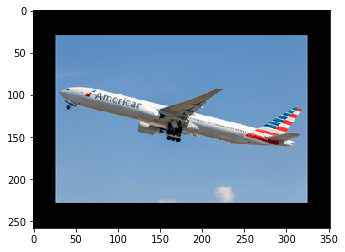

In [ ]:
img2 = Image.open(glob.glob(x_train_folders + type_of_files)[1])
img2.thumbnail(image_size, Image.ANTIALIAS)
plt.imshow(img2)
plt.show()

In [ ]:
file_1 = segmentations_paths[0]
tar = image.load_img(file_1, target_size = image_size)
tar = image.img_to_array(tar)                        # - преобразование картинки в массив
tar = np.expand_dims(tar, axis = 0)                  # - ? не понятен механизм работы
tar = tar[:,:,:,0]                                   # - ? не понятно
print(tar[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Формирование сети

In [ ]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


def unet(num_classes = 6, input_shape= (352, 480, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # Load pretrained weights.
    for_pretrained_weight = MaxPooling2D()(x)
    vgg16 = Model(img_input, for_pretrained_weight)
    vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model
  
palette = {0:(30, 50, 70),1:(0, 140, 55),2:(70, 222, 70),3:(33, 55, 150),4:(220, 127, 45),5:(100, 40, 80), 6:(150, 150, 150),
          7:(100, 0, 0), 8:(0, 0, 100), 9:(10, 40, 100), 10:(140, 140, 80), 11:(180, 180, 50)}

def color_encode(x, palette):
  R = np.zeros(x[0].shape)
  G = np.zeros(x[0].shape)
  B = np.zeros(x[0].shape)
  for cat in palette:
    R[x[0] == cat] = palette[cat][0]
    G[x[0] == cat] = palette[cat][1]
    B[x[0] == cat] = palette[cat][2]
  img = np.zeros(x.shape)
  img = np.expand_dims(img, axis = 3)
  img = np.dstack((R, G, B))
  img = image.array_to_img(img)
  return img

def show_colored(img_path, palette):
  ar = image.load_img(img_path, target_size = (352, 480))
  ar = image.img_to_array(ar)
  ar = ar[:,:,0]
  R = np.zeros(ar.shape)
  G = np.zeros(ar.shape)
  B = np.zeros(ar.shape)
  for cat in palette:
    R[ar == cat] = palette[cat][0]
    G[ar == cat] = palette[cat][1]
    B[ar == cat] = palette[cat][2]
  img = np.zeros(ar.shape)
  img = np.expand_dims(img, axis = 3)
  img = np.dstack((R, G, B))
  img = image.array_to_img(img)
  #plt.imshow(img)
  return img

def show_3(n, image_size, model):
  image_list1 = glob.glob('./dataset2/images_prepped_test/*.png')
  img1 = image.load_img(image_list1[n], target_size = image_size)
  image_list2 = glob.glob('./dataset2/annotations_prepped_test/*.png')
  img2 = show_colored(image_list2[n], palette)
  ar = image.img_to_array(img1)
  ar = np.expand_dims(ar, axis = 0)
  x = model.predict(ar)
  x = x.argmax(axis = 3)
  img3 = color_encode(x, palette)
  
  fig, ax = plt.subplots(1, 3, figsize = (15,5))
  
  ax[0].imshow(img1)
  ax[0].axis('off')
  ax[1].imshow(img2)
  ax[1].axis('off')
  ax[2].imshow(img3)
  ax[2].axis('off')

## Запуск тренировки

### Сеть с метриками :  loss='jaccard_loss', metrics=['iou_score']

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf


сheckpoint = ModelCheckpoint('./testNN_{epoch:02d}-{iou_score:.4f}.hdf5', 
                              monitor='iou_score', 
                             save_best_only=True)

def jaccard_distance(y_true, y_pred, smooth=15):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))    
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))    
    jac = (intersection + smooth) / (sum_ - intersection + smooth)    
    jd =  (1 - jac) * smooth    
    return tf.reduce_mean(jd)

def iou_loss_core(y_true, y_pred, smooth=2):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou


#stop = EarlyStopping(monitor='iou_score', mode='max', verbose=1, restore_best_weights = True)

#model1 = Unet('resnet34', input_shape=(352,480, 3), intencoder_weights='imagenet', classes=classes_count, activation='softmax')
model1 = Unet('resnet34', input_shape=(352,480, 3), classes=classes_count, activation='softmax')
#model1.compile('Adam', loss='jaccard_loss', metrics=['iou_score'])
model1.compile('Adam', loss= jaccard_distance, metrics=[iou_loss_core])

#для сохранения весов каждые 10 эпох. обучаемся пока не остановим
i = 0
history = []

#learning_rate_reduction = ReduceLROnPlateau(monitor = 'loss', factor=0.5, patience=3,
#                              verbose=0, mode='auto', min_delta=0.00001,
#                              cooldown=0, min_lr=0)
batch_size = 20
#while True:
  #history = model.fit_generator(generator(), steps_per_epoch=256, epochs=10,callbacks = [сheckpoint])
model1.fit_generator(datagen_(image_size,batch_size,classes_count), steps_per_epoch=80, epochs=4)
  #model.save_weights('./testNN_'+str(i)+'.HDF5')
  #i = i + 1

### Сеть с метриками : loss='categorical_crossentropy', metrics=[dice_coef]

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


сheckpoint = ModelCheckpoint('./testNN_{epoch:02d}-{dice_coef:.4f}.hdf5', 
                              monitor='dice_coef', 
                             save_best_only=True)

stop = EarlyStopping(monitor='dice_coef', mode='max', verbose=1, restore_best_weights = True)

#model2 = Unet('resnet34', input_shape=(352,480, 3), intencoder_weights='imagenet', classes=classes_count, activation='softmax')
model2 = Unet('resnet34', input_shape=(352,480, 3), classes=classes_count, activation='softmax')
#model.compile('Adam', loss='jaccard_loss', metrics=['iou_score'])
model2.compile('Adam', loss='categorical_crossentropy', metrics=[dice_coef])
#для сохранения весов каждые 10 эпох. обучаемся пока не остановим
i = 0
history = []

#learning_rate_reduction = ReduceLROnPlateau(monitor = 'loss', factor=0.5, patience=3,
#                              verbose=0, mode='auto', min_delta=0.00001,
#                              cooldown=0, min_lr=0)
batch_size = 10
#while True:
  #history = model.fit_generator(generator(), steps_per_epoch=256, epochs=10,callbacks = [сheckpoint])
#model2.fit_generator(datagen_(image_size,batch_size,classes_count), steps_per_epoch=128, epochs=10, callbacks = [сheckpoint,stop])
model2.fit_generator(datagen_(image_size,batch_size,classes_count),  steps_per_epoch=80, epochs=4)
  #model.save_weights('./testNN_'+str(i)+'.HDF5')
  #i = i + 1


### Сеть с метриками : loss='categorical_crossentropy', metrics=[antidice]

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def antidice(y_true, y_pred):
    return 1.- ((2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.))


сheckpoint = ModelCheckpoint('./testNN_{epoch:02d}-{antidice:.4f}.hdf5', 
                              monitor='antidice', 
                             save_best_only=True)
stop = EarlyStopping(monitor='antidice', mode='max', verbose=1, restore_best_weights = True)

model3 = Unet('resnet34', input_shape=(352,480, 3), classes=classes_count, activation='softmax')
#model.compile('Adam', loss='jaccard_loss', metrics=['iou_score'])
model3.compile('Adam', loss='categorical_crossentropy', metrics=[antidice])
#для сохранения весов каждые 10 эпох. обучаемся пока не остановим
i = 0
history = []

#learning_rate_reduction = ReduceLROnPlateau(monitor = 'loss', factor=0.5, patience=3,
#                              verbose=0, mode='auto', min_delta=0.00001,
#                              cooldown=0, min_lr=0)
batch_size = 16
#while True:
  #history = model.fit_generator(generator(), steps_per_epoch=256, epochs=10,callbacks = [сheckpoint])
#model3.fit_generator(datagen_(image_size,batch_size,classes_count), steps_per_epoch=128, epochs=5, callbacks = [сheckpoint,stop])
model3.fit_generator(datagen_(image_size,batch_size,classes_count), steps_per_epoch=128, epochs=7)
  #model.save_weights('./testNN_'+str(i)+'.HDF5')
  #i = i + 1


## Выведем примеры работы всех сетей для сравнения:

In [ ]:
import random

size_test_exmpl = 10

def rand(s,size_test_exmpl):
    x = []
    for i in range(size_test_exmpl):
        x.append(random.randint(0,s))
    return x

size = len(glob.glob(x_test_folder + type_of_files))
test_ = rand(size,size_test_exmpl)
print(test_)

[45, 0, 12, 70, 40, 70, 9, 19, 74, 14]


### Сеть с метриками : loss='jaccard_loss', metrics=['iou_score']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:173: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


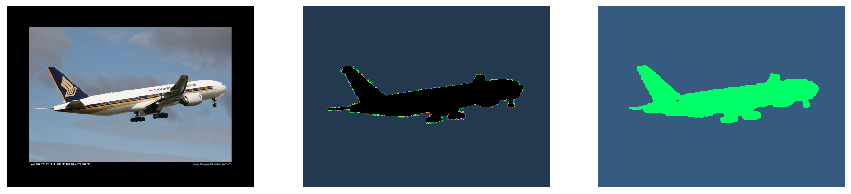

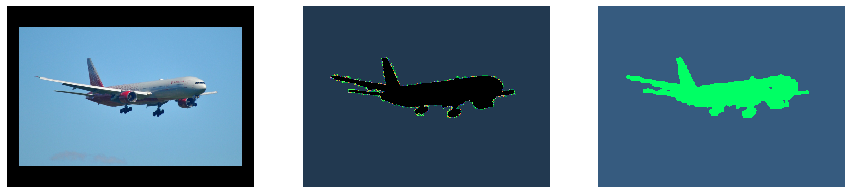

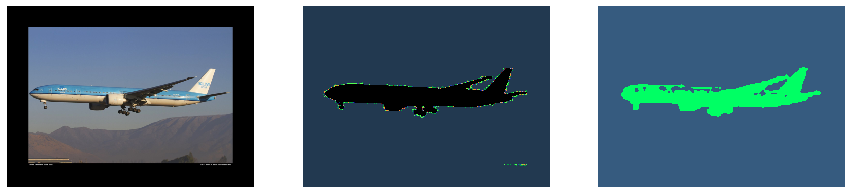

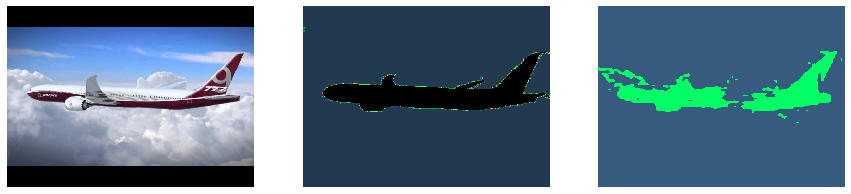

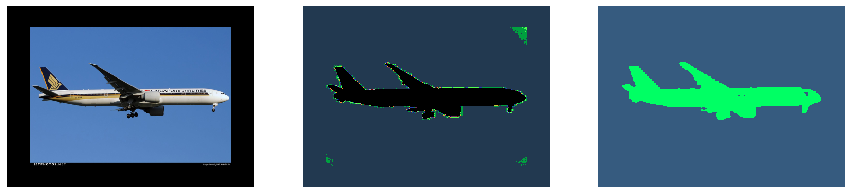

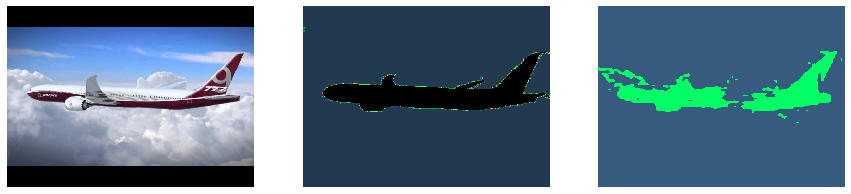

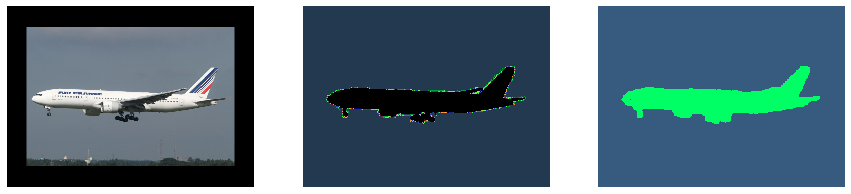

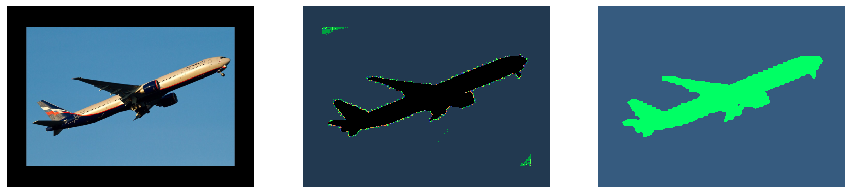

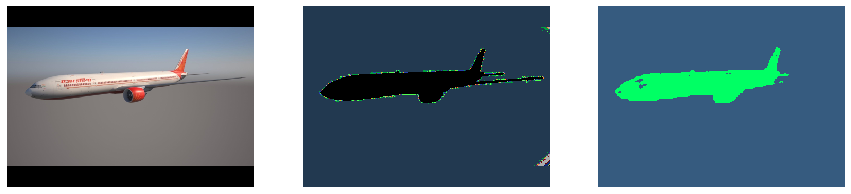

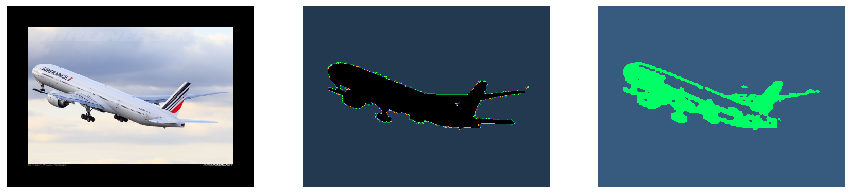

In [ ]:
for n in test_:
    show_3(n, (352,480), model1)

### Сеть с метриками : loss='categorical_crossentropy', metrics=[dice_coef]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:173: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


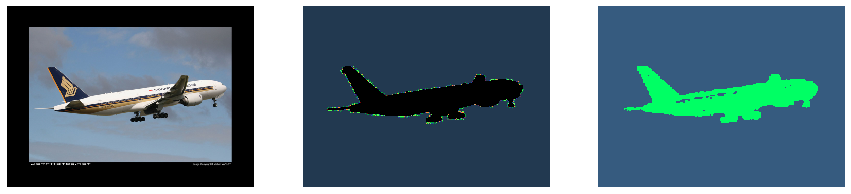

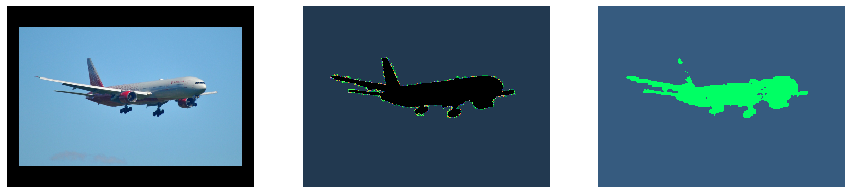

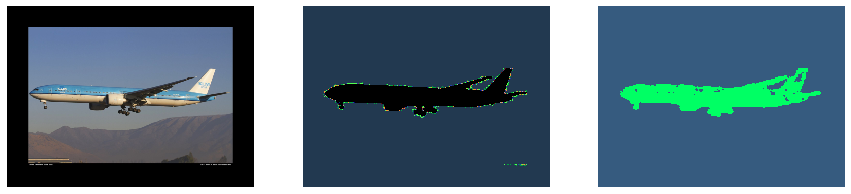

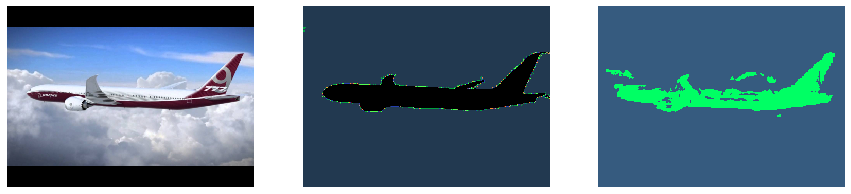

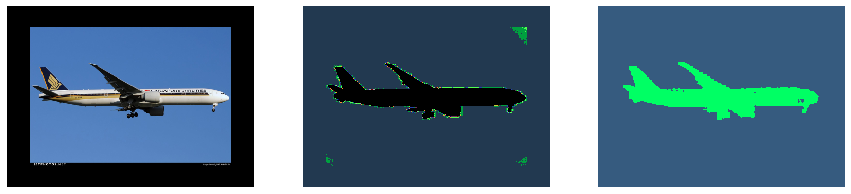

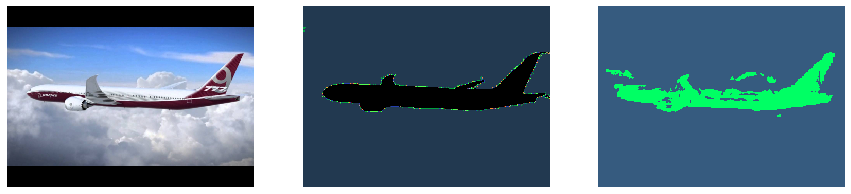

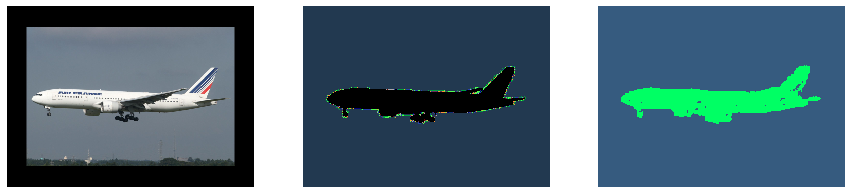

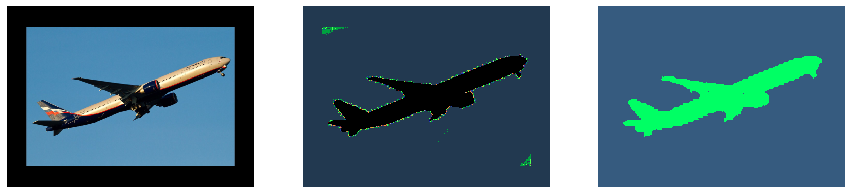

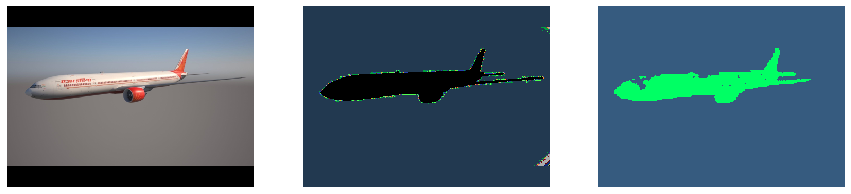

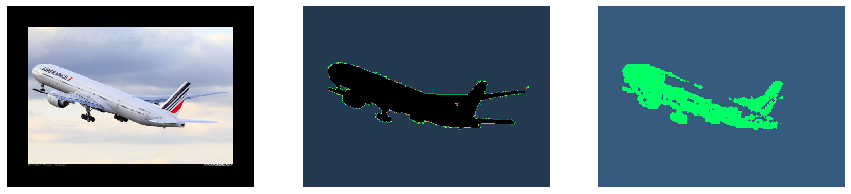

In [ ]:
for n in test_:
    show_3(n, (352,480), model2)

### Сеть с метриками : loss='categorical_crossentropy', metrics=[antidice]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:173: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


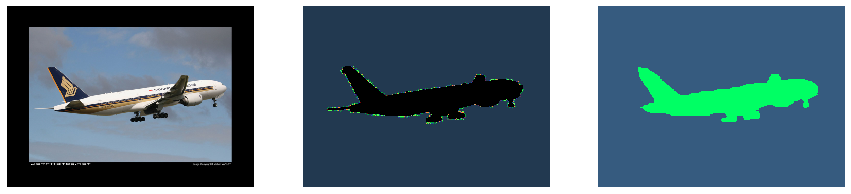

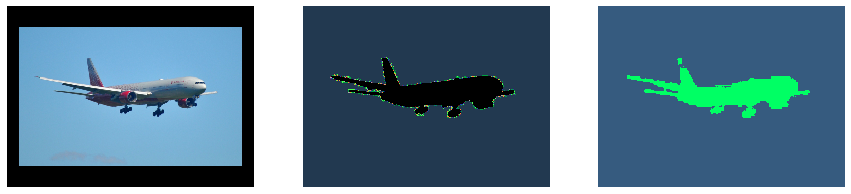

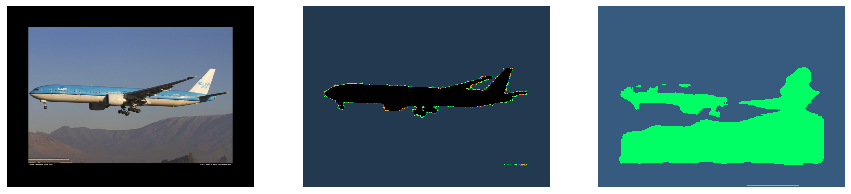

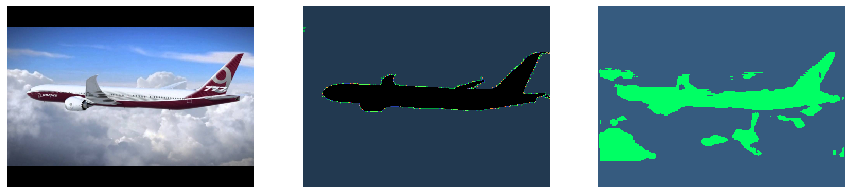

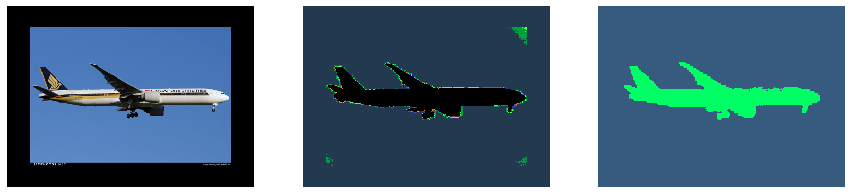

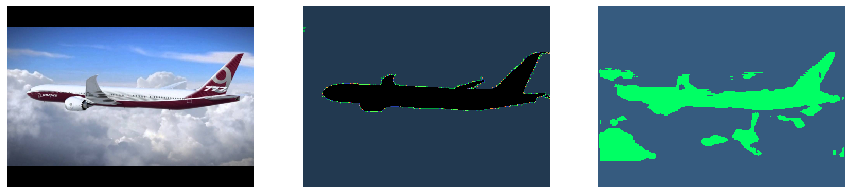

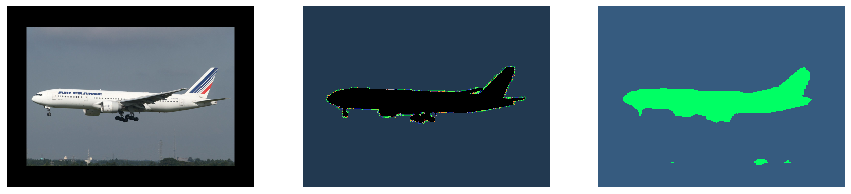

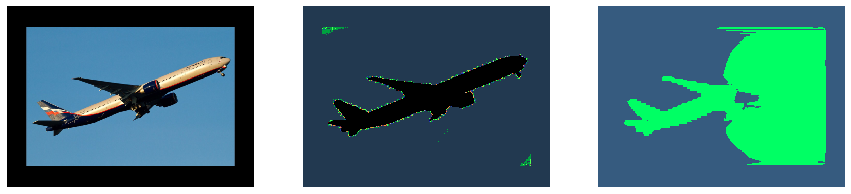

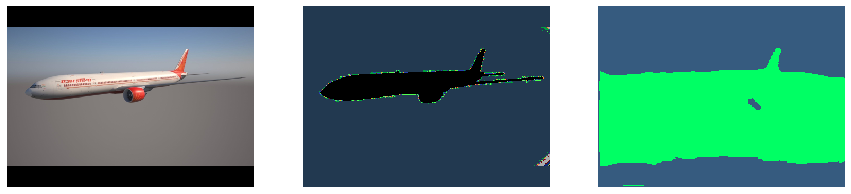

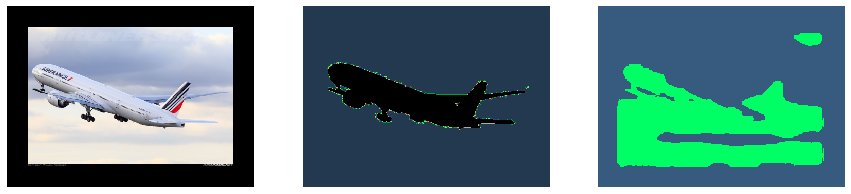

In [ ]:
for n in test_:
    show_3(n, (352,480), model3)